In [1]:
#importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gmaps
import requests
import json

#google developer API key
#from config import gkey


In [2]:
#Reading in CSV files

raw_income_df = pd.read_csv("../Resources/Income_data_with_overlays.csv")

#Hospital data was not encoded in UTF-8, recommended we try windows 1252 encoding
raw_ratings_df = pd.read_csv("../Resources/HospitalGeneralInformation.csv", encoding = 'cp1252')

In [3]:
#CLEANING DATA

In [4]:
#Cleaning up Income Data (condensed to one cell see EdgarMapping notebook for breakdown and notes)

#Creating a list to hold the desired column names
newColumnNames = []

#Loop through columns adding the first row item to list holding the new desired column names
for column in raw_income_df.columns:
    name = raw_income_df.loc[0,column]
    newColumnNames.append(name)
    
#Changing column names to the correct names
raw_income_df.columns = newColumnNames

#Removing no longer needed first data row
raw_income_df.drop([0], inplace=True)

#List of the rows we want to keep
columns_to_keep = ['Geographic Area Name',
                   'Estimate!!Households!!Total',
                   'Estimate!!Households!!Total!!Less than $10,000',
                   'Estimate!!Households!!Total!!$10,000 to $14,999',
                   'Estimate!!Households!!Total!!$15,000 to $24,999',
                   'Estimate!!Households!!Total!!$25,000 to $34,999',
                   'Estimate!!Households!!Total!!$35,000 to $49,999',
                   'Estimate!!Households!!Total!!$50,000 to $74,999',
                   'Estimate!!Households!!Total!!$75,000 to $99,999',
                   'Estimate!!Households!!Total!!$100,000 to $149,999',
                   'Estimate!!Households!!Total!!$150,000 to $199,999',
                   'Estimate!!Households!!Total!!$200,000 or more',
                   'Estimate!!Households!!Median income (dollars)',
                   'Estimate!!Households!!Mean income (dollars)'
                  ]

#Creating a new dataframe that keeps only the columns we want to analyze
income_df = raw_income_df.loc[:,columns_to_keep]

#Clean up column names now that we have the correct columns
#List of new names to be used
clean_names = ['State',
               'Total Households',
               '<$10,000(%)',
               '$10,000 to $14,999(%)',
               '$15,000 to $24,999(%)',
               '$25,000 to $34,999(%)',
               '$35,000 to $49,999(%)',
               '$50,000 to $74,999(%)',
               '$75,000 to $99,999(%)',
               '$100,000 to $149,999(%)',
               '$150,000 to $199,999(%)',
               '>$200,000(%)',
               'Median Income(dollars)',
               'Mean Income(dollars)'
              ]

#Change the badly formatted Column names to the list of clean names
income_df.columns = clean_names
income_df['Median Income(dollars)'] = income_df['Median Income(dollars)'].astype(float)

#Show Final clean income DF
income_df.head()

,State,Total Households,"<$10,000(%)","$10,000 to $14,999(%)","$15,000 to $24,999(%)","$25,000 to $34,999(%)","$35,000 to $49,999(%)","$50,000 to $74,999(%)","$75,000 to $99,999(%)","$100,000 to $149,999(%)","$150,000 to $199,999(%)",">$200,000(%)",Median Income(dollars),Mean Income(dollars)
1,Alabama,1855184,9.1,6.0,11.9,10.1,13.0,17.4,12.0,12.1,4.4,4.0,49861.0,69091
2,Alaska,254551,4.5,3.3,6.4,6.6,10.3,19.3,13.4,19.0,8.3,8.8,74346.0,96080
3,Arizona,2614298,6.0,3.6,9.5,9.3,13.5,19.1,13.1,14.2,5.7,5.8,59246.0,80477
4,Arkansas,1156347,8.2,6.1,12.3,11.3,15.2,17.8,10.6,11.3,3.8,3.6,47062.0,66766
5,California,13072122,5.1,3.9,7.5,7.2,10.4,15.6,12.3,16.6,8.9,12.4,75277.0,107384


In [5]:
#Cleaning hospital rating data

#Listing the columns to keep
columns_to_keep = ['Hospital Name',
                    'Address',
                    'City',
                    'State',
                    'ZIP Code',
                    'County Name',
                    'Hospital Type',
                    'Hospital Ownership',
                    'Hospital overall rating',
                    'Mortality national comparison',
                    'Safety of care national comparison',
                    'Readmission national comparison',
                    'Patient experience national comparison',
                    'Effectiveness of care national comparison',
                    'Timeliness of care national comparison',
                    'Efficient use of medical imaging national comparison'
                   ]

#Creating new DF(ratings_df) with only columns of interest
ratings_df = raw_ratings_df.loc[:,columns_to_keep]

#Removing Rows where overall rating is "not available"
ratings_df = ratings_df[ratings_df['Hospital overall rating'] != "Not Available"]

#converting the overall ratings column to numeric type
ratings_df['Hospital overall rating'] = ratings_df['Hospital overall rating'].astype(float)


#TESTING TO SEE NEW DF
print(ratings_df.dtypes)
ratings_df.head()

Hospital Name                                            object
Address                                                  object
City                                                     object
State                                                    object
ZIP Code                                                  int64
County Name                                              object
Hospital Type                                            object
Hospital Ownership                                       object
Hospital overall rating                                 float64
Mortality national comparison                            object
Safety of care national comparison                       object
Readmission national comparison                          object
Patient experience national comparison                   object
Effectiveness of care national comparison                object
Timeliness of care national comparison                   object
Efficient use of medical imaging nationa

,Hospital Name,Address,City,State,ZIP Code,County Name,Hospital Type,Hospital Ownership,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison
0,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,Acute Care Hospitals,Government - Hospital District or Authority,3.0,Same as the national average,Above the national average,Same as the national average,Below the national average,Same as the national average,Same as the national average,Same as the national average
1,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,Acute Care Hospitals,Government - Hospital District or Authority,3.0,Below the national average,Same as the national average,Above the national average,Same as the national average,Same as the national average,Above the national average,Below the national average
2,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,Acute Care Hospitals,Government - Hospital District or Authority,2.0,Below the national average,Same as the national average,Same as the national average,Below the national average,Same as the national average,Above the national average,Same as the national average
3,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,Acute Care Hospitals,Voluntary non-profit - Private,2.0,Same as the national average,Not Available,Below the national average,Same as the national average,Below the national average,Above the national average,Not Available
4,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,Acute Care Hospitals,Proprietary,3.0,Same as the national average,Not Available,Same as the national average,Not Available,Same as the national average,Above the national average,Not Available


In [6]:
#AVG HOSPITAL RATINGS BY STATE 

In [7]:
#average of all numerical values - including hospital overall rating
#New variable called group_ratings 
grouped_ratings = ratings_df.groupby(["State"]).mean()
grouped_ratings.head()

,ZIP Code,Hospital overall rating
State,,
AK,99644.444444,2.888889
AL,35949.696203,3.050633
AR,72258.945455,2.836364
AZ,85483.703704,2.944444
CA,93172.082759,2.841379


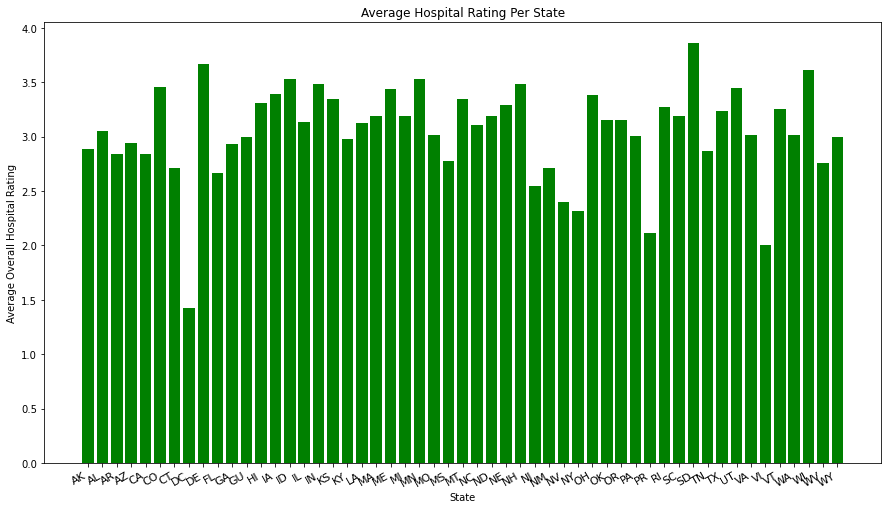

In [8]:
#Grouped_Ratings are used for x and y; x needs to be the index column of the grouped ratings df 
x = grouped_ratings.index
y = grouped_ratings['Hospital overall rating']

#Adjustment of figure size so it isn't compressed horizontally
plt.rcParams["figure.figsize"] = (15,9)

#Bar chart with data
plt.bar(x,y, color='g', alpha=1, align='center')

#x-axis font size
plt.tick_params(axis='x', which='major', labelsize=11)

#slanted x-axis labels
plt.gcf().autofmt_xdate()

# Set a Title and labels
plt.title("Average Hospital Rating Per State")
plt.xlabel("State")
plt.ylabel("Average Overall Hospital Rating")

plt.show()

In [9]:
#COMPARING INCOME AND RATINGS

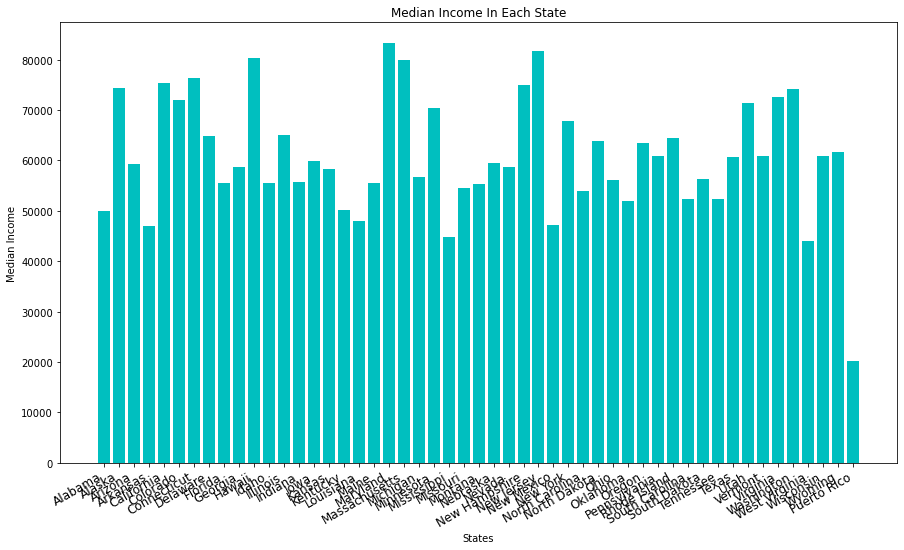

In [10]:
# Plotting Median income for each state

x = income_df['State']
y = income_df['Median Income(dollars)']
plt.bar(x,y , color='c', alpha=1, align="center")

#ADJUST FIGURE SIZE TO NOT HAVE IT COMPRESSED HORIZONTALLY
plt.rcParams["figure.figsize"] = (30,10)

# make x labels slanted
plt.gcf().autofmt_xdate()

#font size for x axis
plt.tick_params(axis='x', which='major', labelsize=12)

#Labels
plt.title('Median Income In Each State')
plt.xlabel('States')
plt.ylabel('Median Income')

plt.show()

In [11]:
# Plotting median income vs average state hospital ratings

#extract state and hospital ratings
state_and_ratings_df = ratings_df[["State","Hospital overall rating"]]
#state_and_ratings_df
state_mean_df = state_and_ratings_df.groupby(['State']).mean()
state_mean_df.head()

,Hospital overall rating
State,
AK,2.888889
AL,3.050633
AR,2.836364
AZ,2.944444
CA,2.841379


In [12]:
#Renaming, turning abbreviations to state names
state_names = ['Alaska',
               'Alabama',
               'Arkansas',
               'Arizona',
               'California',
               'Colorado',
               'Connecticut',
               'District of Columbia',
               'Delaware',
               'Florida',
               'Georgia',
               'Guam',
               'Hawaii',
               'Iowa',
               'Indiana',
               'Illinois',
               'Indiana',
               'Kansas',
               'Kentucky',
               'Louisiana',
               'Massachusetts',
               'Maine',
               'Michigan',
               'Minnesota',
               'Missouri',
               'Mississippi',
               'Montana',
               'North Carolina',
               'North Dakota',
               'Nebraska',
               'New Hampshire',
               'New Jersey',
               'New Mexico',
               'Nevada',
               'New York',
               'Ohio',
               'Oklahoma',
               'Oregon',
               'Pennsylvania',
               'Puerto Rico',
               'Rhode Island',
               'South Carolina',
               'South Dakota',
               'Tennessee',
               'Texas',
               'Utah',
               'Virginia',
               'Virgin Islands',
               'Vermont',
               'Washington',
               'Wisconsin',
               'West Virginia',
               'Wyoming'
             ] 
state_mean_df['State Name']=state_names
state_mean_df.head()

,Hospital overall rating,State Name
State,,
AK,2.888889,Alaska
AL,3.050633,Alabama
AR,2.836364,Arkansas
AZ,2.944444,Arizona
CA,2.841379,California


In [13]:
#cleanup 
state_mean_clean_df = state_mean_df.loc[:,['State Name','Hospital overall rating']]
state_mean_clean_df.head()

,State Name,Hospital overall rating
State,,
AK,Alaska,2.888889
AL,Alabama,3.050633
AR,Arkansas,2.836364
AZ,Arizona,2.944444
CA,California,2.841379


In [14]:
#Created a new income dataframe with only state and median income columns
income_compare_df = income_df.loc[:,['State','Median Income(dollars)']]

#changed the column names to match the comparison ratings dataframe(specifically State Name)
income_compare_df.columns = ['State Name', 'Median Income(dollars)']
income_compare_df.head()

,State Name,Median Income(dollars)
1,Alabama,49861.0
2,Alaska,74346.0
3,Arizona,59246.0
4,Arkansas,47062.0
5,California,75277.0


In [15]:
#combing datasets
merge_df = pd.merge(income_compare_df,state_mean_clean_df, on='State Name',how='inner')
merge_df.head()

,State Name,Median Income(dollars),Hospital overall rating
0,Alabama,49861.0,3.050633
1,Alaska,74346.0,2.888889
2,Arizona,59246.0,2.944444
3,Arkansas,47062.0,2.836364
4,California,75277.0,2.841379


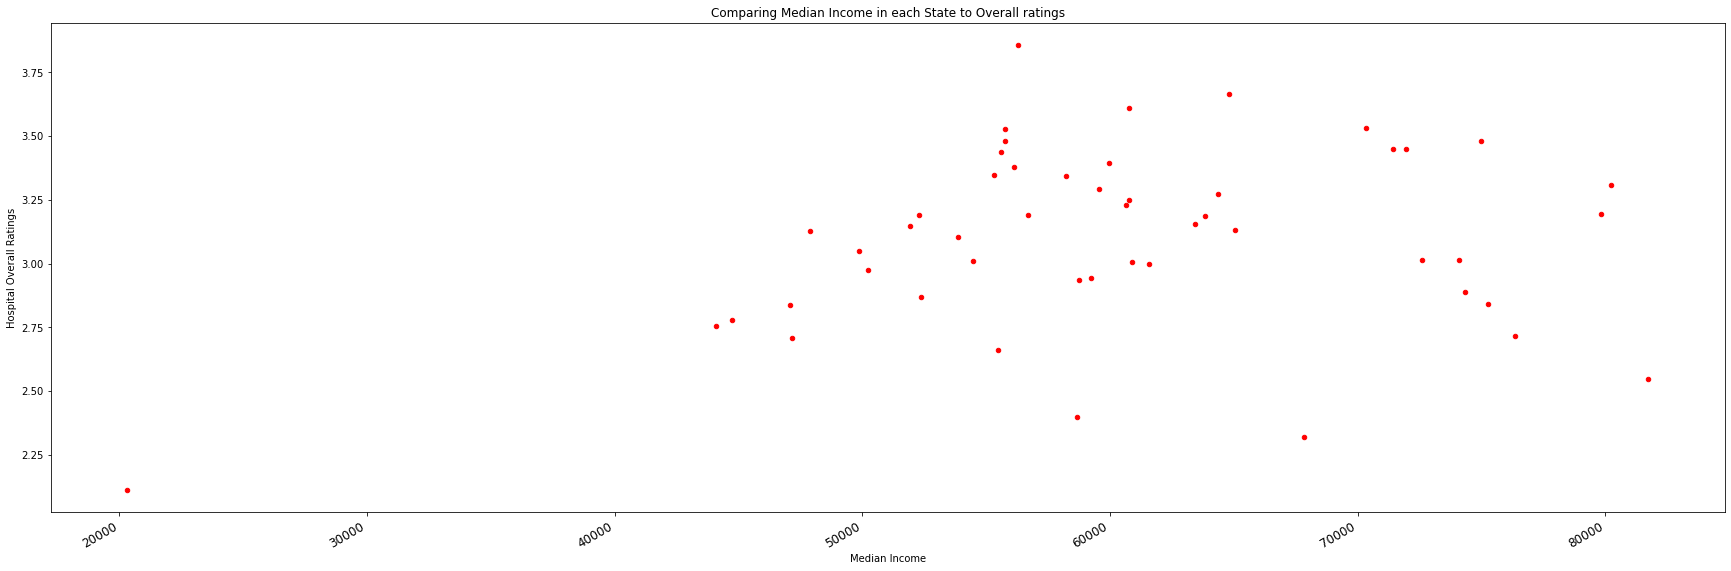

In [16]:
merge_df.plot(kind='scatter',x='Median Income(dollars)',y='Hospital overall rating',color='r')

#ADJUST FIGURE SIZE TO NOT HAVE IT COMPRESSED HORIZONTALLY
plt.rcParams["figure.figsize"] = (10,10)

# make x labels slanted
plt.gcf().autofmt_xdate()

#font size for x axis
plt.tick_params(axis='x', which='major', labelsize=12)

#Labels
plt.title('Comparing Median Income in each State to Overall ratings')
plt.xlabel('Median Income')
plt.ylabel('Hospital Overall Ratings')

plt.show()

In [17]:
#MAPPING HIGHLY RATED HOSPITALS

In [18]:
#Create a Dataframe with hospitals rated above X overall rating


top_hospital_df = ratings_df.loc[ratings_df['Hospital overall rating'] > 4]

Latitudes = []
Longitudes = []
 
top_hospital_df.head()

,Hospital Name,Address,City,State,ZIP Code,County Name,Hospital Type,Hospital Ownership,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison
23,MARION REGIONAL MEDICAL CENTER,1256 MILITARY STREET SOUTH,HAMILTON,AL,35570,MARION,Acute Care Hospitals,Voluntary non-profit - Private,5.0,Same as the national average,Not Available,Same as the national average,Above the national average,Same as the national average,Above the national average,Not Available
65,LAKELAND COMMUNITY HOSPITAL,42024 HIGHWAY 195 E,HALEYVILLE,AL,35565,WINSTON,Acute Care Hospitals,Voluntary non-profit - Church,5.0,Above the national average,Not Available,Above the national average,Same as the national average,Same as the national average,Above the national average,Same as the national average
76,BAPTIST MEDICAL CENTER EAST,400 TAYLOR ROAD,MONTGOMERY,AL,36117,MONTGOMERY,Acute Care Hospitals,Government - Hospital District or Authority,5.0,Same as the national average,Above the national average,Above the national average,Above the national average,Same as the national average,Below the national average,Same as the national average
145,MAYO CLINIC HOSPITAL,5777 EAST MAYO BOULEVARD,PHOENIX,AZ,85054,MARICOPA,Acute Care Hospitals,Voluntary non-profit - Private,5.0,Above the national average,Above the national average,Above the national average,Above the national average,Same as the national average,Same as the national average,Same as the national average
146,BANNER HEART HOSPITAL,6750 EAST BAYWOOD AVENUE,MESA,AZ,85206,MARICOPA,Acute Care Hospitals,Voluntary non-profit - Private,5.0,Above the national average,Above the national average,Above the national average,Above the national average,Not Available,Not Available,Not Available


In [19]:
#Create params for api call
params = {"key": gkey}

In [21]:
#Loop through rows of the top hospitals DF to pull Lat and Long from google api and add to DF

for index, row in top_hospital_df.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json?"

    #Pull Address from the dataframe and add to params for api call
    params['address'] = f"{row['Address']},{row['City']},{row['State']}"
    
    #Make request to google api and convert to json
    hospital_geodata = requests.get(base_url, params=params).json()
    
    #Add Longitude and Latitude to Lists
    Latitudes.append(hospital_geodata["results"][0]["geometry"]["location"]["lat"])
    Longitudes.append(hospital_geodata["results"][0]["geometry"]["location"]["lng"])
    
top_hospital_df['Lat']=Latitudes
top_hospital_df['Lng']=Longitudes
top_hospital_df.head()

<ipython-input-21-c1c4f609e2cb>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_hospital_df['Lat']=Latitudes
<ipython-input-21-c1c4f609e2cb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_hospital_df['Lng']=Longitudes


,Hospital Name,Address,City,State,ZIP Code,County Name,Hospital Type,Hospital Ownership,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison,Lat,Lng
23,MARION REGIONAL MEDICAL CENTER,1256 MILITARY STREET SOUTH,HAMILTON,AL,35570,MARION,Acute Care Hospitals,Voluntary non-profit - Private,5.0,Same as the national average,Not Available,Same as the national average,Above the national average,Same as the national average,Above the national average,Not Available,34.126225,-87.990891
65,LAKELAND COMMUNITY HOSPITAL,42024 HIGHWAY 195 E,HALEYVILLE,AL,35565,WINSTON,Acute Care Hospitals,Voluntary non-profit - Church,5.0,Above the national average,Not Available,Above the national average,Same as the national average,Same as the national average,Above the national average,Same as the national average,34.241956,-87.591402
76,BAPTIST MEDICAL CENTER EAST,400 TAYLOR ROAD,MONTGOMERY,AL,36117,MONTGOMERY,Acute Care Hospitals,Government - Hospital District or Authority,5.0,Same as the national average,Above the national average,Above the national average,Above the national average,Same as the national average,Below the national average,Same as the national average,32.376024,-86.174858
145,MAYO CLINIC HOSPITAL,5777 EAST MAYO BOULEVARD,PHOENIX,AZ,85054,MARICOPA,Acute Care Hospitals,Voluntary non-profit - Private,5.0,Above the national average,Above the national average,Above the national average,Above the national average,Same as the national average,Same as the national average,Same as the national average,33.659052,-111.956450
146,BANNER HEART HOSPITAL,6750 EAST BAYWOOD AVENUE,MESA,AZ,85206,MARICOPA,Acute Care Hospitals,Voluntary non-profit - Private,5.0,Above the national average,Above the national average,Above the national average,Above the national average,Not Available,Not Available,Not Available,33.411242,-111.688921


In [22]:
#GMAPS needs a list of tuples for the marker layer

#creating a list to hold hospital coordinates
hospital_coordinates = []

#creating a list to hold string for marker descriptions
hospital_info = []

#looping through the rows of the df to create a tuple using the lat and long columns
#and add them to the list above
for index, row in top_hospital_df.iterrows():
    hospital_coordinates.append((row["Lat"],row["Lng"]))
    
    #ATTEMPT at html to make a Description list for hospital information. 
    #triple quote to allow a string to span multiple lines instead of one giant long line
    hospital_info.append(f"""
                        <dl>
                        <dt>Hospital:</dt><dd>{row['Hospital Name']}</dd>
                        <dt>Rating:</dt><dd>{row['Hospital overall rating']}</dd>
                        </dl>""")

In [24]:
#Creating a gmaps marker layer using hospital coordinates list and hospital info list
marker_layer = gmaps.marker_layer(hospital_coordinates,info_box_content=hospital_info)

#Creating a gmaps figure base layer map
fig=gmaps.figure()

#adding the marker layer to the figure base layer map
fig.add_layer(marker_layer)

#show the map
fig

Figure(layout=FigureLayout(height='420px'))

In [25]:
#MAPING OUT CA HOSPITALS W/ 4+ RATING

california_df = ratings_df.loc[ratings_df['State']=="CA"]
california_df = california_df[california_df['Hospital overall rating']>3]

Latitudes = []
Longitudes = []

In [26]:
#Loop through rows of the DF to pull Lat and Long from google api and add to DF

for index, row in california_df.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json?"

    
    #Pull Address from the dataframe and add to params for api call
    params['address'] = f"{row['Address']},{row['City']},{row['State']}"
    
    #Make request to google api and convert to json
    hospital_geodata = requests.get(base_url, params=params).json()
    
    #Add Longitude and Latitude to Dataframe
   # hospital_df.loc[index,"Lat"] = hospital_geodata["results"][0]["geometry"]["location"]["lat"]
    #hospital_df.loc[index,"Lng"] = hospital_geodata["results"][0]["geometry"]["location"]["lng"]
    #List instead
    Latitudes.append(hospital_geodata["results"][0]["geometry"]["location"]["lat"])
    Longitudes.append(hospital_geodata["results"][0]["geometry"]["location"]["lng"])
    
california_df['Lat']=Latitudes
california_df['Lng']=Longitudes
california_df.head()

,Hospital Name,Address,City,State,ZIP Code,County Name,Hospital Type,Hospital Ownership,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison,Lat,Lng
261,MILLS-PENINSULA MEDICAL CENTER,1501 TROUSDALE DRIVE,BURLINGAME,CA,94010,SAN MATEO,Acute Care Hospitals,Voluntary non-profit - Private,4.0,Above the national average,Same as the national average,Above the national average,Above the national average,Same as the national average,Same as the national average,Same as the national average,37.591609,-122.383717
285,KAWEAH DELTA MEDICAL CENTER,400 W MINERAL KING AVE,VISALIA,CA,93291,TULARE,Acute Care Hospitals,Government - Hospital District or Authority,4.0,Same as the national average,Above the national average,Above the national average,Below the national average,Same as the national average,Below the national average,Same as the national average,36.328572,-119.294958
296,KAISER FOUNDATION HOSPITAL - SAN FRANCISCO,2425 GEARY BLVD,SAN FRANCISCO,CA,94115,SAN FRANCISCO,Acute Care Hospitals,Voluntary non-profit - Other,4.0,Not Available,Same as the national average,Not Available,Above the national average,Same as the national average,Not Available,Not Available,37.782459,-122.443097
302,SONOMA VALLEY HOSPITAL,347 ANDRIEUX ST,SONOMA,CA,95476,SONOMA,Acute Care Hospitals,Government - Hospital District or Authority,4.0,Same as the national average,Same as the national average,Above the national average,Same as the national average,Same as the national average,Same as the national average,Same as the national average,38.288150,-122.465688
307,SHARP MEMORIAL HOSPITAL,7901 FROST ST,SAN DIEGO,CA,92123,SAN DIEGO,Acute Care Hospitals,Voluntary non-profit - Other,4.0,Same as the national average,Above the national average,Above the national average,Above the national average,Above the national average,Same as the national average,Above the national average,32.799676,-117.154600


In [27]:
#creating a list to hold hospital coordinates
hospital_coordinates = []
#creating a list to hold string for marker descriptions
hospital_info = []

#looping through the rows of the df to create a tuple using the lat and long columns
#and add them to the list above
for index, row in california_df.iterrows():
    hospital_coordinates.append((row["Lat"],row["Lng"]))
    #ATTEMPT at html to make a Description list for hospital information. 
    #triple quote to allow a string to span multiple lines instead of one giant long line
    hospital_info.append(f"""
                        <dl>
                        <dt>Hospital:</dt><dd>{row['Hospital Name']}</dd>
                        <dt>Rating:</dt><dd>{row['Hospital overall rating']}</dd>
                        </dl>""")

In [28]:
#Creating a gmaps marker layer using hospital coordinates list and hospital info list
marker_layer = gmaps.marker_layer(hospital_coordinates,info_box_content=hospital_info)

#Creating a gmaps figure base layer map
fig=gmaps.figure()

#adding the marker layer to the figure base layer map
fig.add_layer(marker_layer)

#show the map
fig

Figure(layout=FigureLayout(height='420px'))